In [3]:
from getpass import getpass

admin_rdm_url = 'https://admin.staging.rdm.example.com/'
idp_name_1 = 'GakuNin RDM IdP'
idp_username_1 = None
idp_password_1 = None
default_result_path = None
close_on_fail = False
transition_timeout = 30000

target_organization = 'GakuNin RDM IdP'

timestamp_project_name = 'TEST-A1-NIIストレージ-ファイル操作-20250426'
timestamp_start_date = '2025-04-15'
timestamp_end_date = '2025-05-01'
timestamp_user = 'Hidefumi Moritani (WF6HN)'

In [4]:
if idp_username_1 is None:
    idp_username_1 = input(prompt=f'Username for {idp_name_1}')
if idp_password_1 is None:
    idp_password_1 = getpass(prompt=f'Password for {idp_username_1}@{idp_name_1}')
(len(idp_username_1), len(idp_password_1))

Username for GakuNin RDM IdP vr_test_admin_01
Password for vr_test_admin_01@GakuNin RDM IdP ········


(16, 20)

# 定期監視-管理者-証跡管理

- サブシステム名: 管理者
- ページ/アドオン: 管理者
- 機能分類: ログイン
- シナリオ名: ログイン確認
- 用意するテストデータ: URL一覧、アカウント(管理者ユーザー1: GRDM)


## GakuNin RDM管理者ページのURLを開く

①ブラウザを開き、画面右上の設定メニューから「シークレットモードで開く」を選択する。  
②新規画面が開かれ、画面上において、「シークレットモードです」と表示されていることを確認する。
以下、シークレットモードにて確認を行う。

③ブラウザを開き、下記URLにアクセスする。  
https://rdm.example.com/  

In [5]:
import tempfile

work_dir = tempfile.mkdtemp()
if default_result_path is None:
    default_result_path = work_dir
work_dir

'/tmp/tmpq8xelybu'

In [121]:
import importlib
import pandas as pd

import scripts.playwright
importlib.reload(scripts.playwright)

from scripts.playwright import *
from scripts import grdm

await init_pw_context(close_on_fail=close_on_fail, last_path=default_result_path)

('20250504-061756', '/tmp/tmpn5_p4efk')

Start epoch: 1746339476.346487 seconds


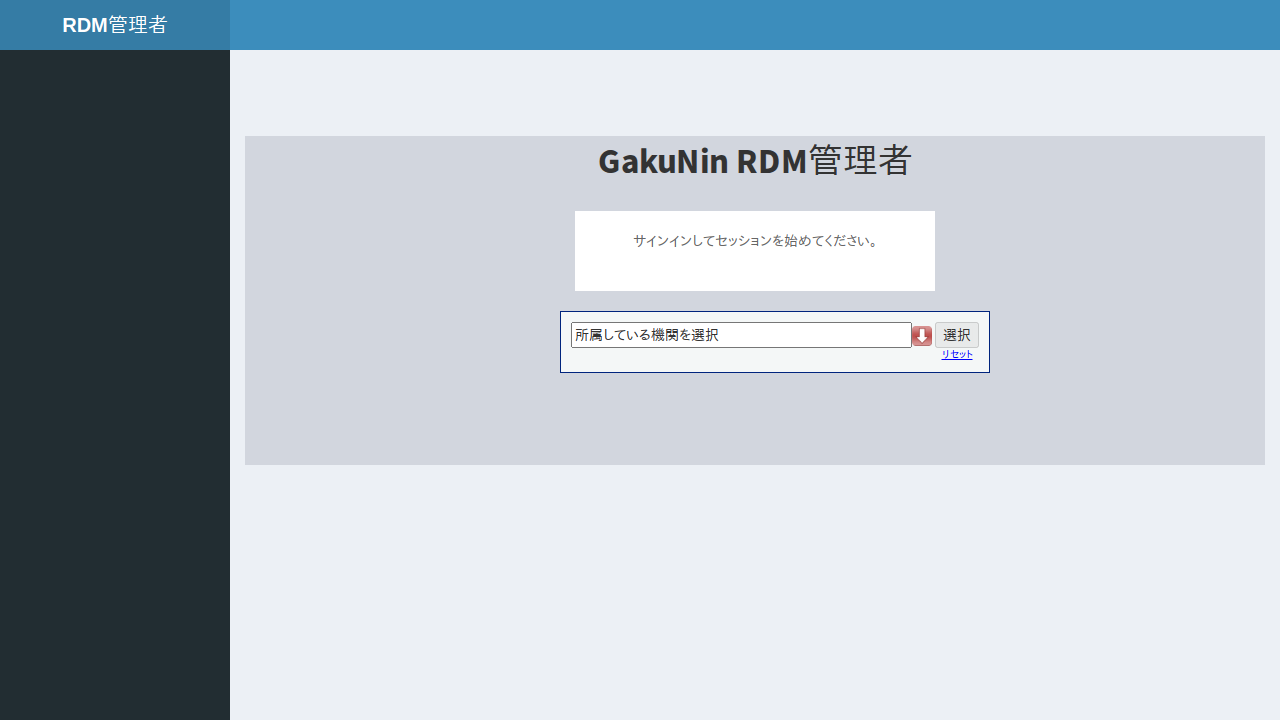

In [122]:
import time

async def _step(page):
    await page.goto(admin_rdm_url)

    await expect(page.locator('.login-logo')).to_be_visible(timeout=30000)

await run_pw(_step)

## ログイン情報を用いてGakuNin RDMにログインする

(IdPに関するログイン情報が与えられた場合、)
GakuNin Embeded DSのプルダウンを展開し、IdPリストから指定されたIdPを選択する。その後、アカウントのID/Passwordを入力して「Login」ボタンを押下する。

(IdPが指定されていない場合、)
CASのログイン操作を実施する。

Start epoch: 1746339476.9989028 seconds


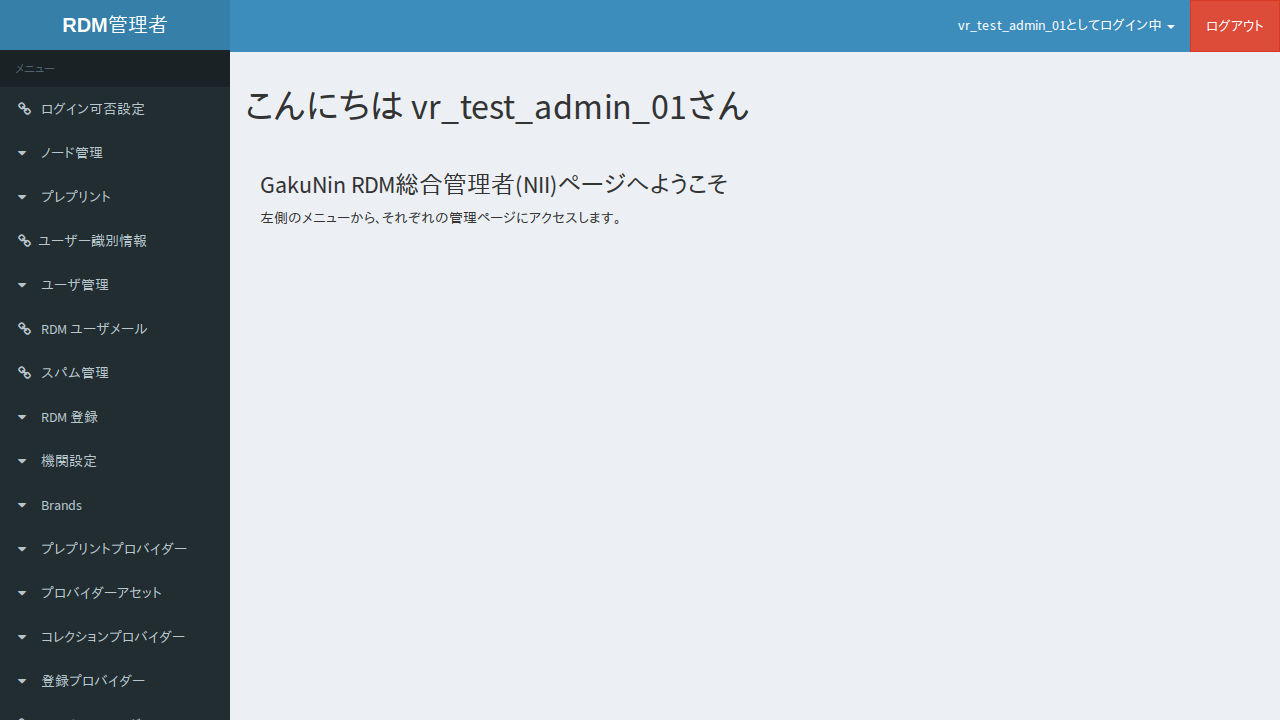

In [123]:
import scripts.grdm
importlib.reload(scripts.grdm)

async def _step(page):
    await scripts.grdm.login_as_admin(
        page, idp_name_1, idp_username_1, idp_password_1, transition_timeout=transition_timeout
    )

    await expect(page.locator('//*[contains(@class, "btn-danger") and contains(text(), "ログアウト")]')).to_be_enabled(timeout=transition_timeout)

await run_pw(_step)

## 「証跡管理」を選択する

「証跡管理」が表示される

Start epoch: 1746339478.8819177 seconds


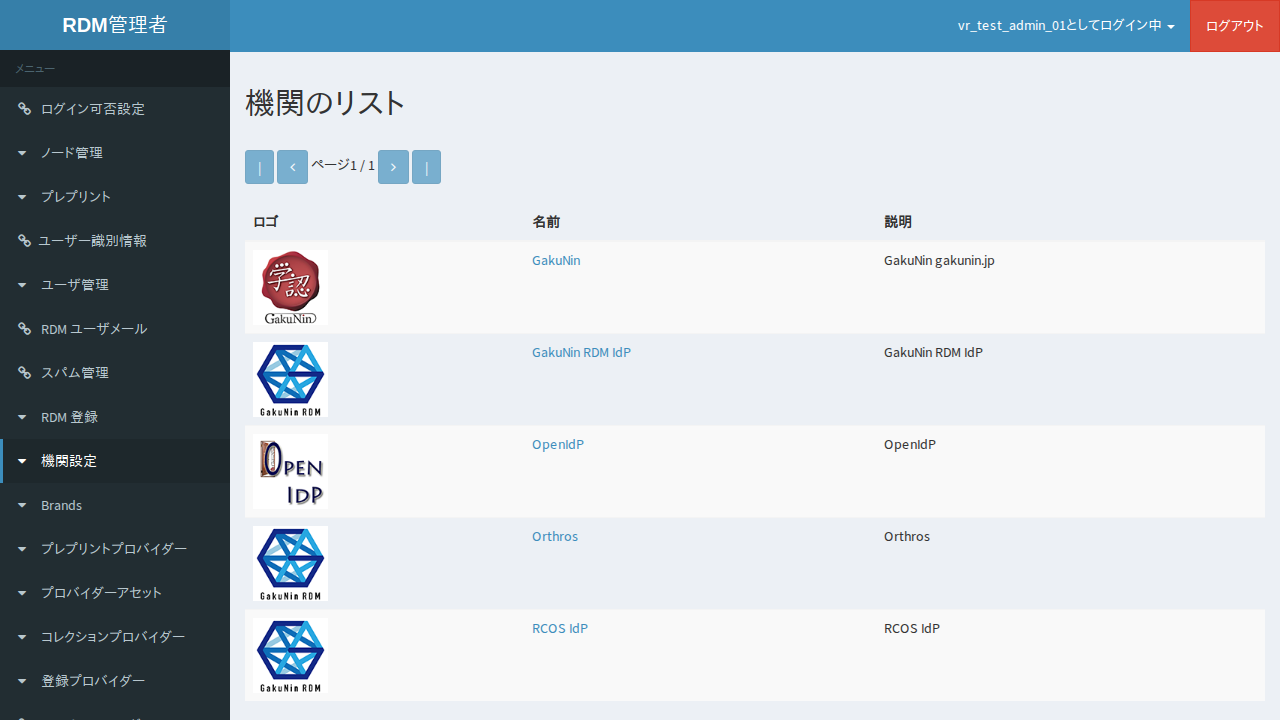

In [124]:
async def _step(page):
    await page.locator('//a[@href = "/timestampadd/"]').click()

    await expect(page.locator('//h2[text() = "機関のリスト"]')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## 「機関のリスト」画面の名前から「GakuNin RDM IdP」を選択する

「GakuNin RDM IdP」の詳細が表示される

Start epoch: 1746339479.2479103 seconds


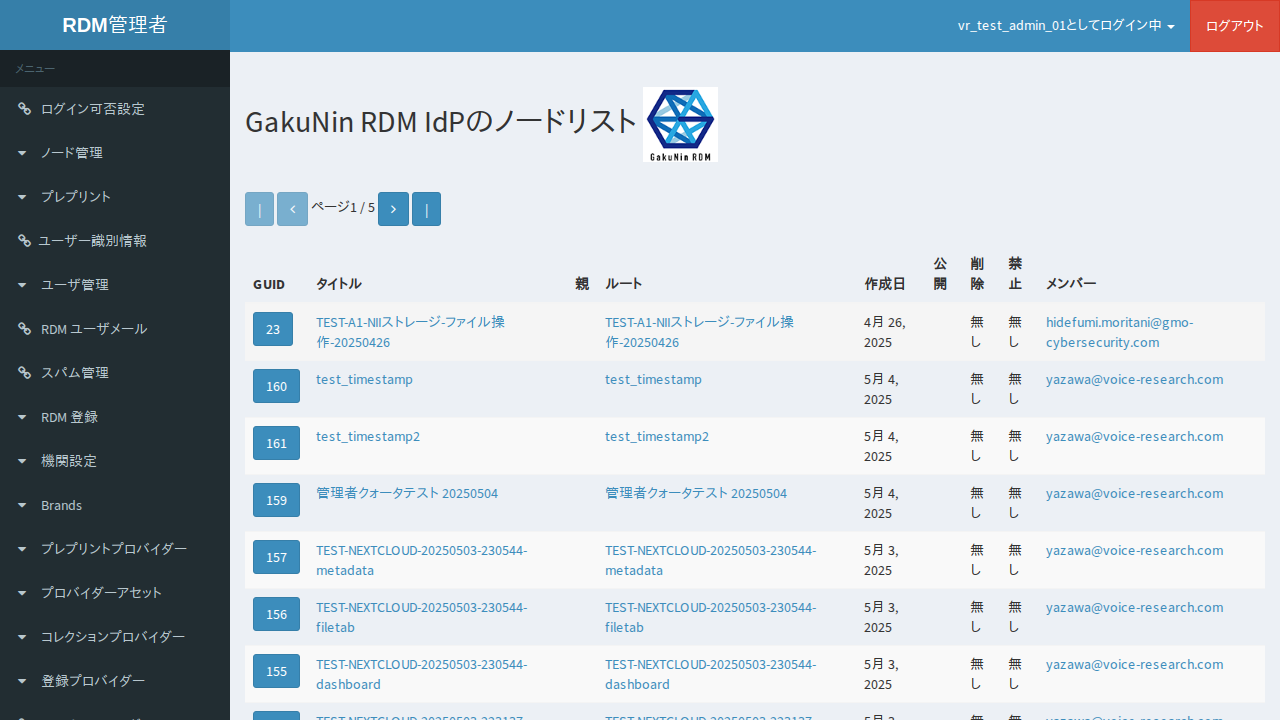

In [125]:
import traceback

async def _step(page):
    while True:
        link = page.locator(f'//a[text() = "{target_organization}"]')
        try:
            await expect(link).to_be_visible()
        except:
            traceback.print_exc()
            print('Search next page...')
            # 次のページかもしれない
            await page.locator('//a[i[contains(@class, "fa-angle-right")]]').click()
            await expect(page.locator('//h2[text() = "機関のリスト"]')).to_be_visible(timeout=transition_timeout)
            continue
        await link.click()
        break

    await expect(page.locator(f'//h2[contains(text(), "{target_organization}のノードリスト")]')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## ページ移動ボタンを押下する

ページが移動し、ページ2ページ目が表示される

Start epoch: 1746339480.536366 seconds


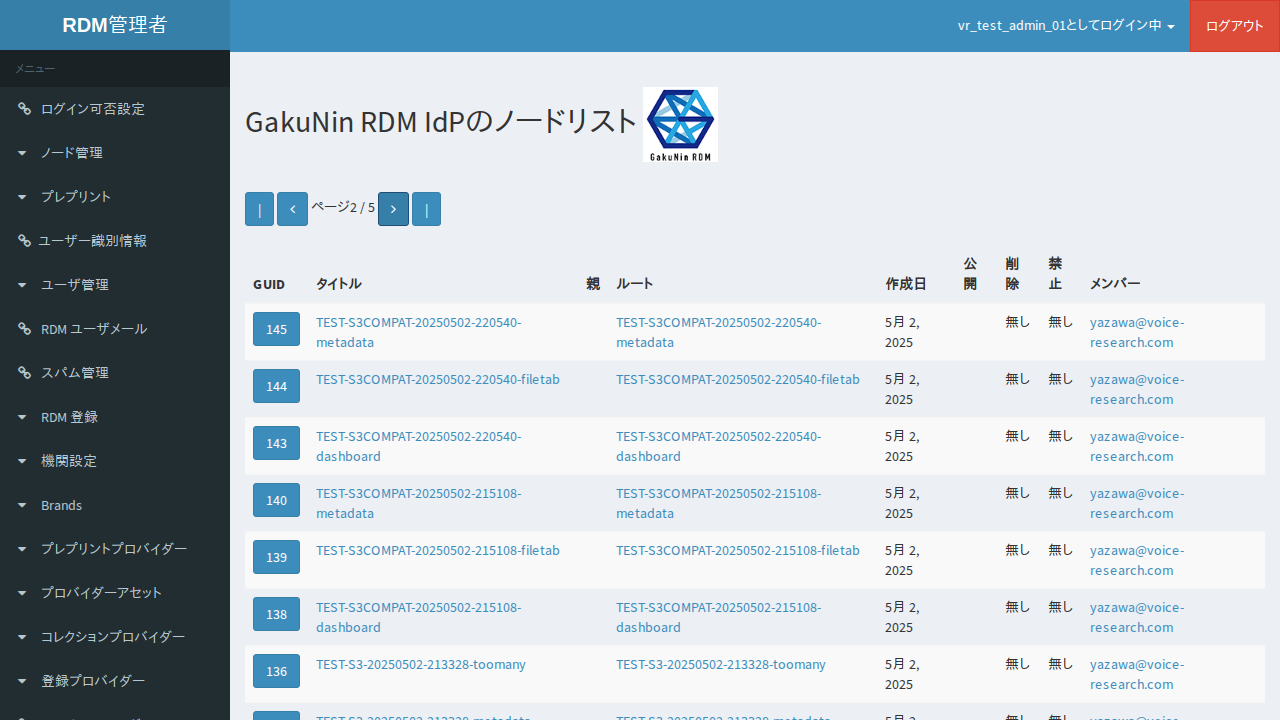

In [126]:
async def _step(page):
    await expect(page.locator('//*[@class = "current" and contains(text(), "ページ1")]')).to_be_visible()

    await page.locator('//a[i[contains(@class, "fa-angle-right")]]').click()
    await expect(page.locator('//*[@class = "current" and contains(text(), "ページ2")]')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## ページ1より、GUID欄の任意のボタンを押下する

証跡管理([対応したタイトル])が表示される
※表示される画面は「タイトル欄」または「ルート欄」を選択しても同様

> 総合試験では「23」を選択。証跡管理(TEST-A1-NIIストレージ-ファイル操作-20250426)が表示

Start epoch: 1746339481.5351553 seconds


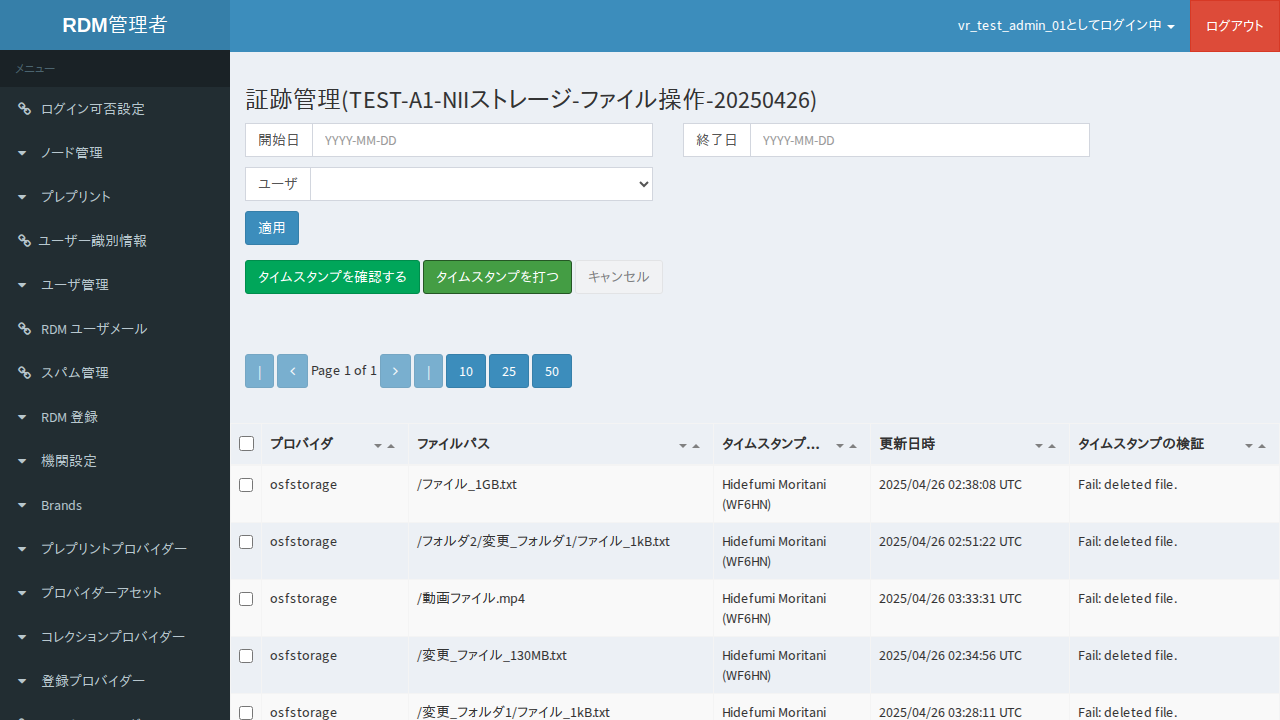

In [127]:
async def _step(page):
    await page.locator('//a[i[contains(@class, "fa-angle-left")]]').click()

    page_num = 1
    while True:
        await expect(page.locator(f'//*[@class = "current" and contains(text(), "ページ{page_num}")]')).to_be_visible()
        count = await page.locator(f'//tr/td[2]/a[contains(text(), "{timestamp_project_name}")]').count()
        if count > 0:
            assert count == 1, count
            break
        # 次のページへ
        await page.locator('//a[i[contains(@class, "fa-angle-right")]]').click()
        page_num += 1
    await page.locator(f'//tr/td[2]/a[contains(text(), "{timestamp_project_name}")]').click()
    await expect(page.locator('//h3[contains(text(), "証跡管理")]')).to_be_visible()

await run_pw(_step)

## 証跡管理フォームの開始日欄をクリックする

Start epoch: 1746339483.208975 seconds


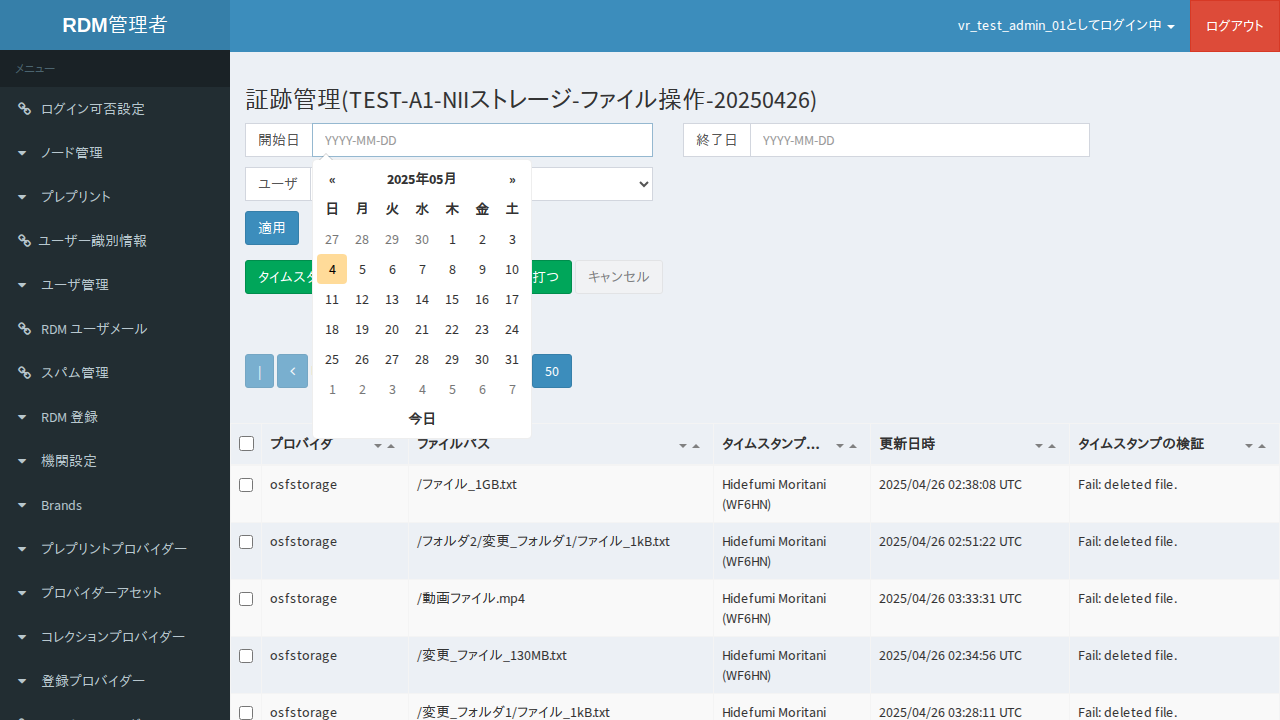

In [128]:
async def _step(page):
    await page.locator('#startDateFilter').click()
    await expect(page.locator('td.today')).to_be_visible()

await run_pw(_step)

## カレンダーにて、日時を選択する

> 日付はテスト仕様で指定されたものとする

Start epoch: 1746339483.4472308 seconds


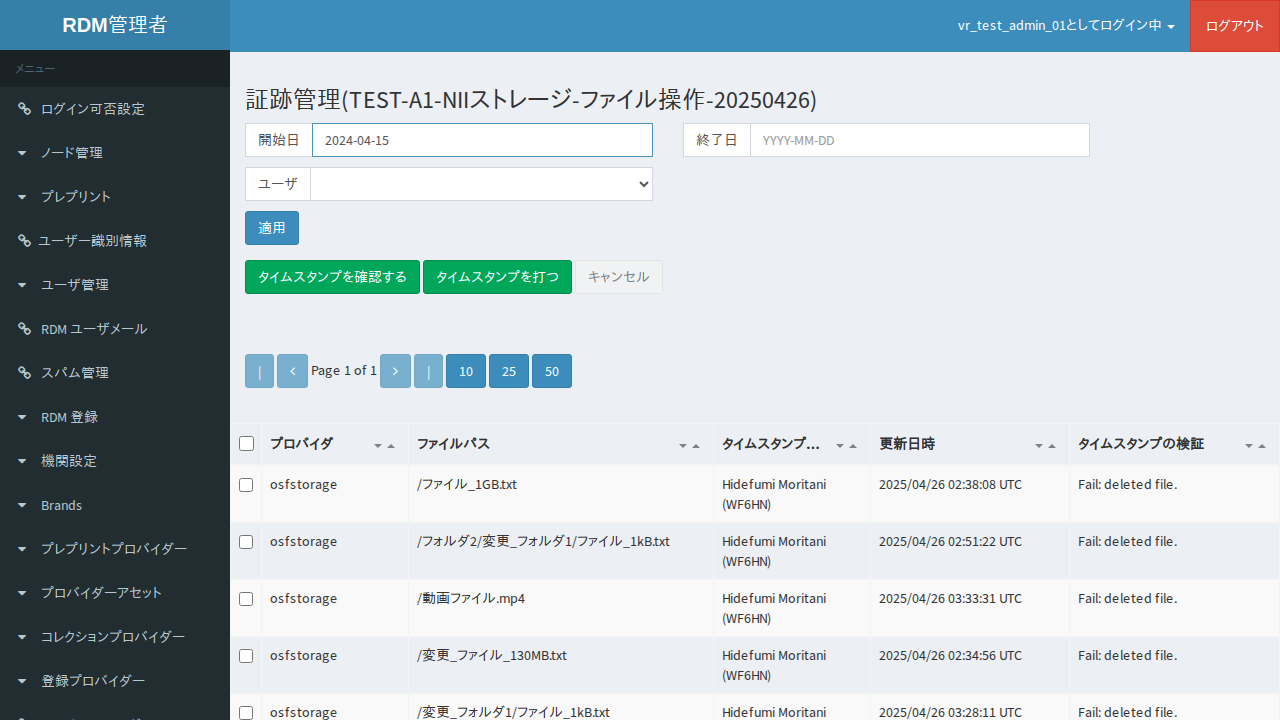

In [129]:
import re

async def select_timestamp(page, timestamp_date):
    m = re.match(r'([0-9]+)-([0-9]+)-([0-9]+)', timestamp_date)
    target_year = m.group(1)
    target_month = m.group(2)
    target_day = m.group(3)
    datepicker_switch = page.locator('.datepicker-switch:visible')
    year_and_month = await datepicker_switch.text_content()
    if year_and_month != f'{target_year}年{target_month}月':
        await datepicker_switch.click()
        year = await datepicker_switch.text_content()
        if year != target_year:
            await datepicker_switch.click()
            await page.locator(f'//*[contains(@class, "year") and text() = "{target_year}"]').click()
            await expect(datepicker_switch).to_have_text(target_year)
        month_int = int(target_month)
        await page.locator(f'//*[contains(@class, "month") and text() = "{month_int}月"]').click()
    await expect(datepicker_switch).to_have_text(f'{target_year}年{target_month}月')
    day_int = int(target_day)
    await page.locator(f'//*[contains(@class, "day") and not(contains(@class, "new")) and text() = "{day_int}"]').click()

async def _step(page):
    await select_timestamp(page, timestamp_start_date)
    await expect(page.locator('#startDateFilter')).to_have_value(timestamp_start_date)
    await page.locator('h3').click()

await run_pw(_step)

## 証跡管理フォームの終了日欄をクリックする

Start epoch: 1746339483.9754183 seconds


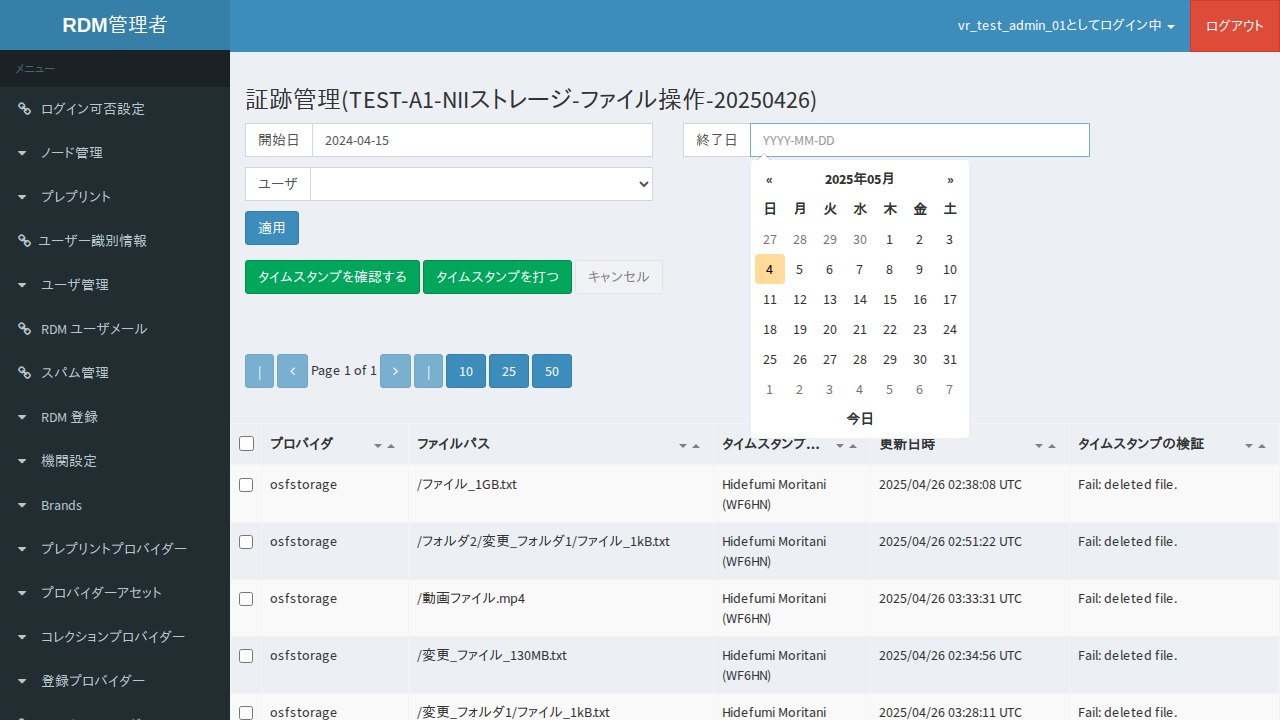

In [130]:
async def _step(page):
    await page.locator('#endDateFilter').click()
    await expect(page.locator('td.today')).to_be_visible()

await run_pw(_step)

## カレンダーにて、日時を選択する

Start epoch: 1746339484.2279162 seconds


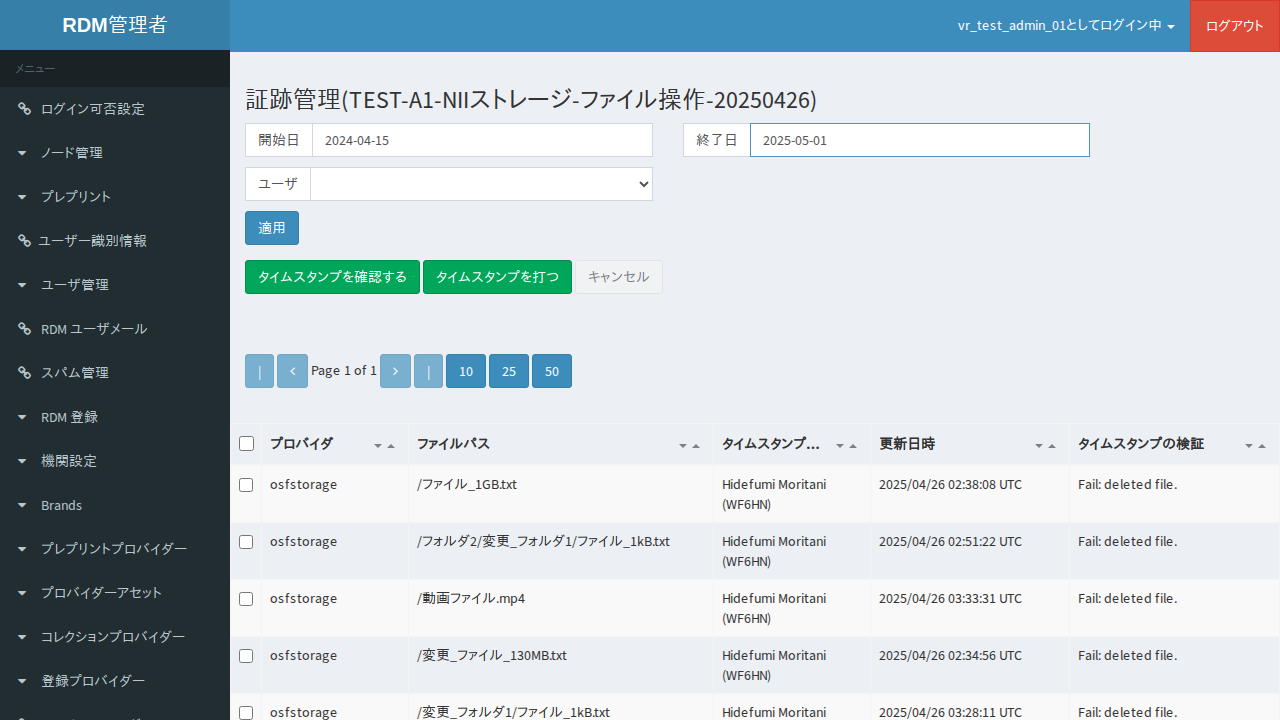

In [131]:
import re

async def _step(page):
    await select_timestamp(page, timestamp_end_date)
    await expect(page.locator('#endDateFilter')).to_have_value(timestamp_end_date)
    await page.locator('h3').click()

await run_pw(_step)

## 証跡管理フォームのユーザー欄のプルダウンを選択する

Start epoch: 1746339484.489389 seconds


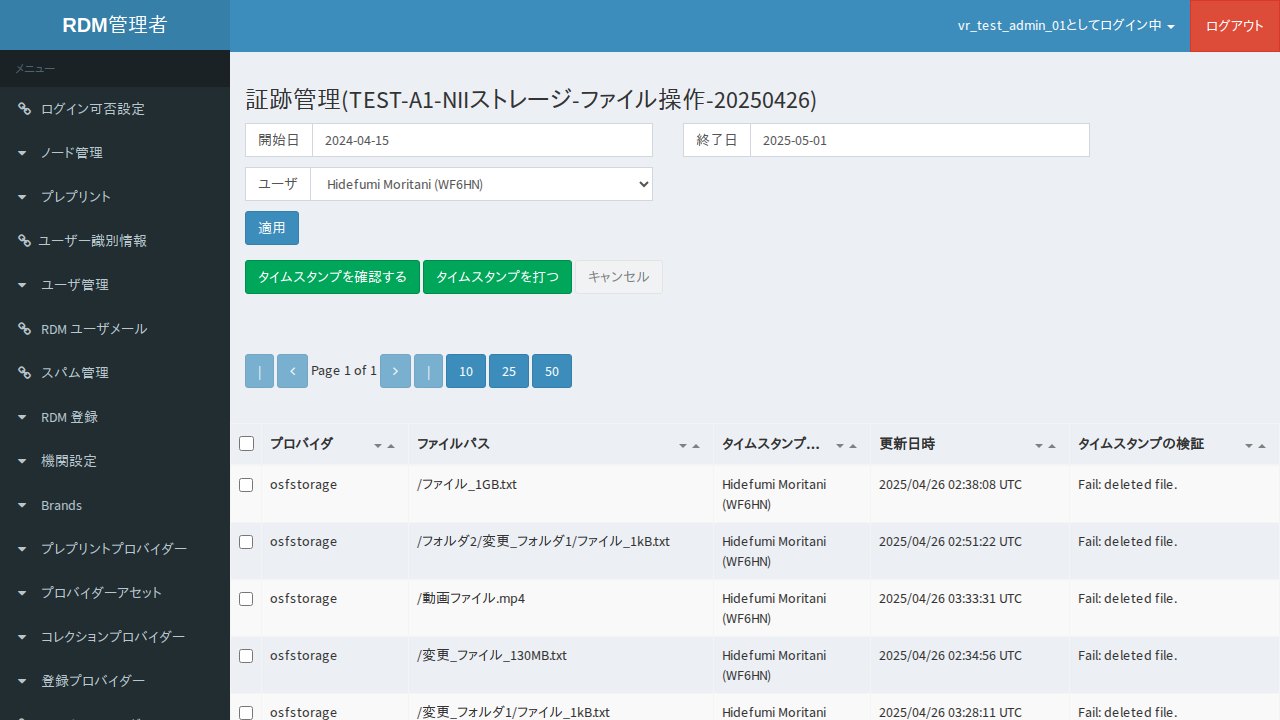

In [132]:
import re

async def _step(page):
    await page.locator(f'//*[@id = "userFilterSelect"]').select_option(timestamp_user)

await run_pw(_step)

## 「適用」ボタンを押下する

Start epoch: 1746339484.6566331 seconds


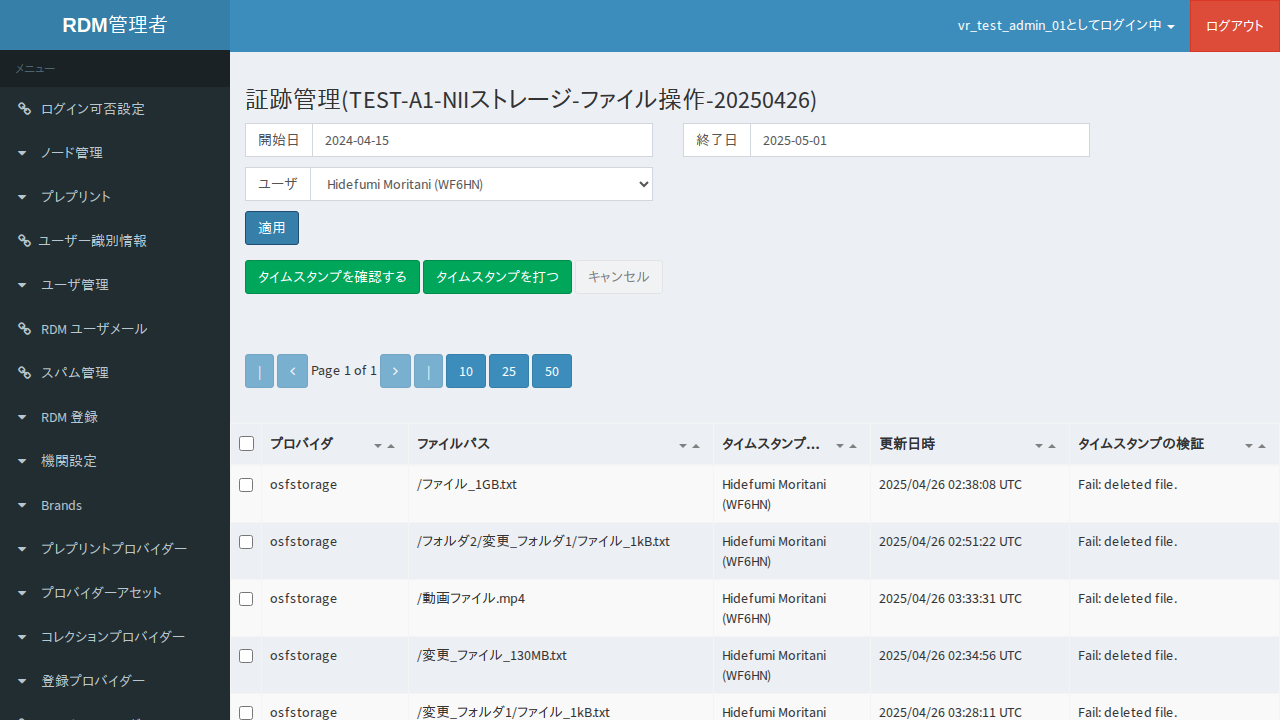

In [133]:
import asyncio

async def _step(page):
    await page.locator('#applyFiltersButton').click()
    await asyncio.sleep(5)

await run_pw(_step)

## 「タイムスタンプを確認する」ボタンを押下する

Start epoch: 1746339489.898576 seconds


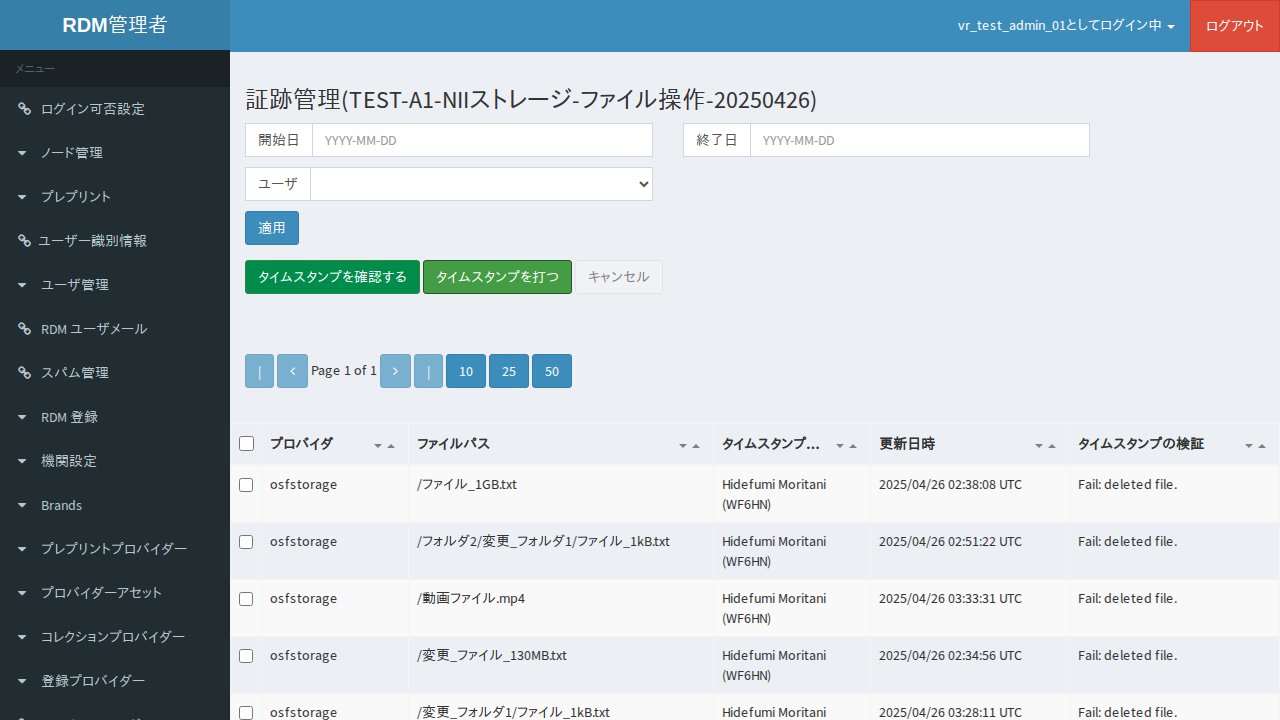

In [134]:
import asyncio

async def _step(page):
    await page.locator('#btn-verify').click()
    await asyncio.sleep(5)

await run_pw(_step)

## 対象ファイルにチェックをいれ、「タイムスタンプを打つ」ボタンを押下する

Start epoch: 1746339495.1410255 seconds


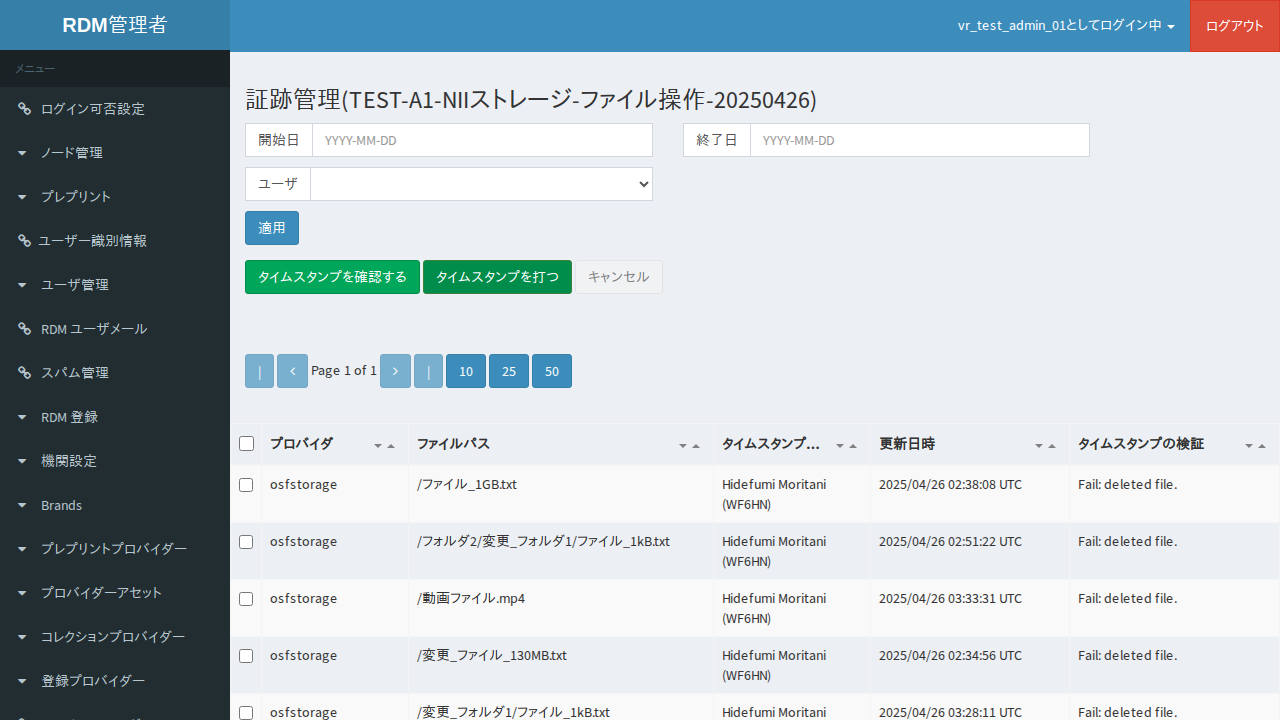

In [135]:
async def _step(page):
    files = await page.locator('.addTimestamp').count()
    await page.locator('#addTimestampAllCheck').click()
    await page.locator('#btn-addtimestamp').click()
    await asyncio.sleep(5)
    await expect(page.locator('.addTimestamp')).to_have_count(files, timeout=transition_timeout)

await run_pw(_step)

## ファイル形式のプルダウンを展開する

「JSON/LD（プルダウン2つ目）」が選択できることを確認する

Start epoch: 1746339500.478403 seconds


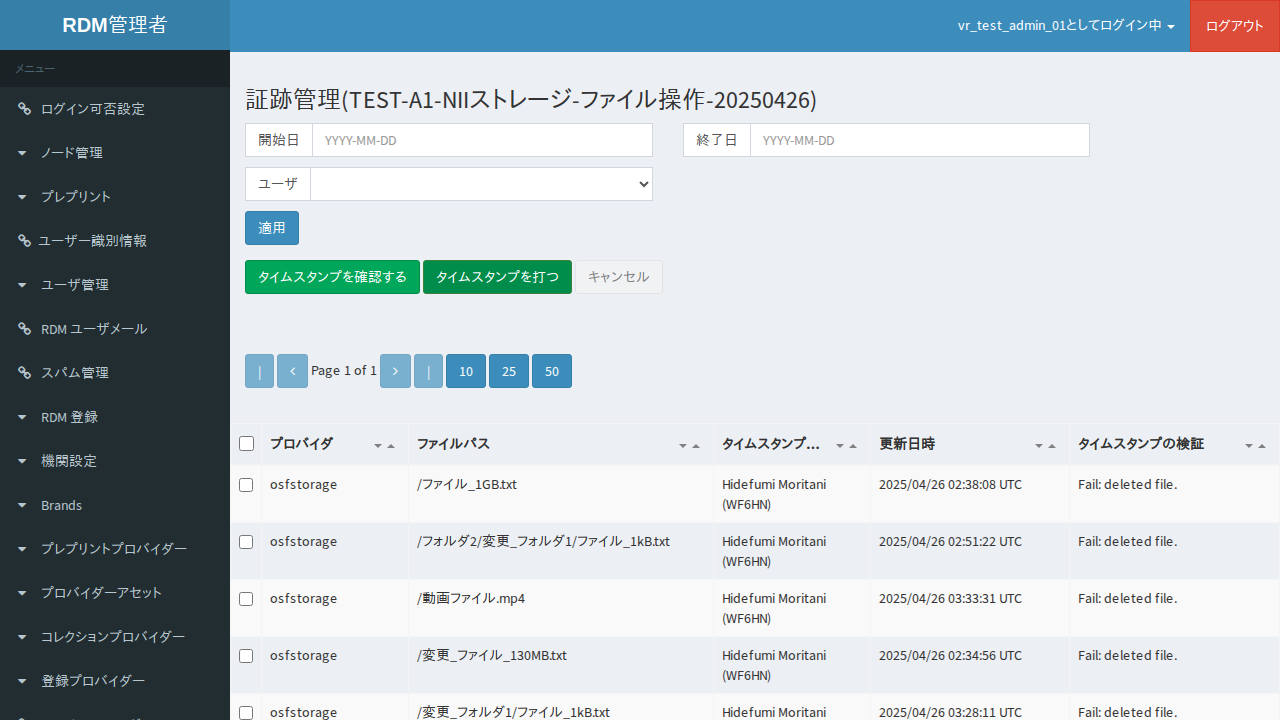

In [136]:
async def _step(page):
    await page.locator('#fileFormat').select_option('JSON/LD')

await run_pw(_step)

## 対象ファイルにチェックをいれ、「ダウンロード」ボタンを押下する

Start epoch: 1746339500.648696 seconds


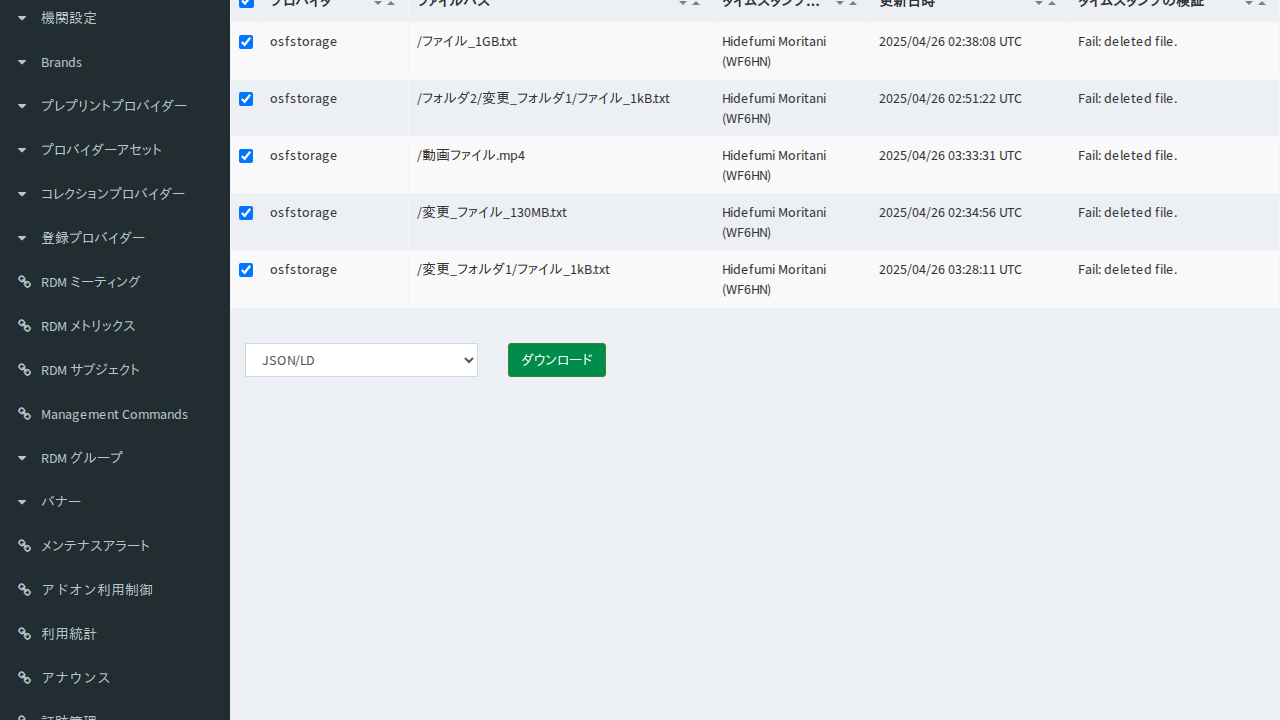

In [137]:
async def _step(page):
    await page.locator('#addTimestampAllCheck').click()
    async with page.expect_download(timeout=transition_timeout * 5) as download_info:
        await page.locator('#btn-download').click()
    download = await download_info.value
    download_dir = os.path.join(work_dir, 'downloaded')
    os.makedirs(download_dir, exist_ok=True)
    download_path = os.path.join(download_dir, download.suggested_filename)
    await download.save_as(download_path)

await run_pw(_step)

In [138]:
!ls -la {work_dir}/downloaded

total 48
drwxr-xr-x 2 jovyan users  4096 May  4 06:18 .
drwx------ 3 jovyan users  4096 May  4 06:16 ..
-rw-r--r-- 1 jovyan users 19884 May  4 06:16 admin_20250504061656_timestamp_errors.json
-rw-r--r-- 1 jovyan users 19884 May  4 06:18 admin_20250504061817_timestamp_errors.json


終了処理を実施。

In [139]:
await finish_pw_context()

Video: /tmp/tmpq8xelybu/video-1.webm
HAR: /tmp/tmpq8xelybu/har.zip


In [140]:
!rm -fr {work_dir}